In [1]:
import os, sys
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath("../anomaly_detection"))
import json
import yaml
from types import SimpleNamespace
from helpers.utils import clean_and_append
from utils import apply_nature_axis_style


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from matplotlib.patches import Patch

def plot_aftercut_naturestyle(
    bootstrap_summary,
    metric_left="mmd",
    metric_right="mean_calibration_difference",
    figsize=(10,4),
    output_dir="plots",
    label_left="MMD",
    label_right=r"$\bar{\Delta}_{\rm calib}$",
    y_min_left=None,
    y_min_right=None,
):
    """
    Two-panel Nature-style bar plot for after-cut metrics.

    - Left panel: metric_left (e.g. "mmd")
    - Right panel: metric_right (e.g. "mean_calibration_difference")
    - X-axis: OS / SS
    - Colors: model types (green/blue scheme)
    - Hatching: calibrated vs uncalibrated
    - Error bars: central 68% interval (16–84% quantiles)
    """

    os.makedirs(output_dir, exist_ok=True)

    # -------------------------------------------------------
    # Convert bootstrap_summary -> long dataframe
    # -------------------------------------------------------
    records = []
    for ibootstrap, summary in bootstrap_summary.items():
        for label, val in summary.items():
            if "after cut" not in val:
                continue

            metrics = val["after cut"]
            group = "OS" if label.endswith("OS") else "SS"
            calibrated = "calibrated" in label
            base_method = (
                label.replace("-OS","")
                     .replace("-SS","")
                     .replace("-calibrated","")
            )

            records.append({
                "bootstrap": ibootstrap,
                "label": label,
                "method": base_method,
                "group": group,
                "calibrated": calibrated,
                "cov": metrics.get("cov", np.nan),
                "mmd": metrics.get("mmd", np.nan),
                "efficiency": metrics.get("efficiency", np.nan),
                "mean_calibration_difference": metrics.get("mean_calibration_difference", np.nan),
                "mean_mass_difference": metrics.get("mean_mass_difference", np.nan),
            })

    df = pd.DataFrame(records)

    if df.empty:
        raise RuntimeError("No 'after cut' entries found in bootstrap_summary.")

    # -------------------------------------------------------
    # Style (Nature-like)
    # -------------------------------------------------------
    sns.set_theme(style="white", font_scale=1.2)
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "pdf.fonttype": 42,
    })

    # -------------------------------------------------------
    # Color scheme: green/blue for models
    # -------------------------------------------------------
    greens = sns.color_palette("Greens", 12)
    blues  = sns.color_palette("Blues", 12)
    MODEL_COLORS = {
        "EveNet-f.t.(SSL)": greens[3],
        "EveNet-f.t.(Cls+Gen)": greens[6],
        "EveNet-f.t.(Cls+Gen+Assign)": greens[9],
        "EveNet-scratch": blues[8],
    }

    detected_methods = sorted(df["method"].unique())

    # Only keep known ones, otherwise fall back to auto palette
    base_methods = [m for m in MODEL_COLORS.keys() if m in detected_methods]
    if len(base_methods) == 0:
        # Fallback: auto-assign colors to whatever is in the data
        print("⚠ WARNING: No method name matched MODEL_COLORS keys.")
        print("   Detected methods:", detected_methods)
        palette = sns.color_palette("viridis", len(detected_methods))
        MODEL_COLORS = {m: palette[i] for i, m in enumerate(detected_methods)}
        base_methods = list(detected_methods)

    n_methods = len(base_methods)
    if n_methods == 0:
        raise RuntimeError("No valid methods found after color assignment.")

    # -------------------------------------------------------
    # Aggregation: central 68% interval (16–84%) per group
    # -------------------------------------------------------
    def agg(metric):
        """
        Returns dict[(method, calibrated)] -> list of 2 tuples:
        [(center_OS, err_low_OS, err_high_OS),
         (center_SS, err_low_SS, err_high_SS)]
        """
        result = {}
        for m in base_methods:
            for cal in [False, True]:
                group_stats = []
                for g in ["OS", "SS"]:
                    tmp = df[(df["method"] == m) &
                             (df["calibrated"] == cal) &
                             (df["group"] == g)][metric].dropna()

                    if len(tmp) > 0:
                        q16, q50, q84 = np.nanpercentile(tmp, [16, 50, 84])
                        center   = q50
                        err_low  = q50 - q16
                        err_high = q84 - q50
                    else:
                        center   = np.nan
                        err_low  = 0.0
                        err_high = 0.0

                    group_stats.append((center, err_low, err_high))
                result[(m, cal)] = group_stats
        return result

    left_data  = agg(metric_left)
    right_data = agg(metric_right)

    # -------------------------------------------------------
    # Plotting helpers
    # -------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)

    def plot_panel(ax, metric_data, ylabel, y_min=None, percentage=False):
        x_groups = ["OS", "SS"]
        n_bars = n_methods * 2
        bar_width = 0.8 / n_bars

        for i, method in enumerate(base_methods):
            for j, cal in enumerate([False, True]):
                centers = [
                    metric_data[(method, cal)][0][0],
                    metric_data[(method, cal)][1][0],
                ]
                err_lows = [
                    metric_data[(method, cal)][0][1],
                    metric_data[(method, cal)][1][1],
                ]
                err_highs = [
                    metric_data[(method, cal)][0][2],
                    metric_data[(method, cal)][1][2],
                ]

                if percentage:
                    centers = [100 * n for n in centers]
                    err_lows = [100 * n for n in err_lows]
                    err_highs = [100 * n for n in err_highs]

                xpos = (
                    np.arange(2)
                    + (i * 2 + j - n_bars / 2 + 0.5) * bar_width
                )

                color = MODEL_COLORS[method]
                hatch = None if cal else "//"
                fill_color = color if cal else sns.light_palette(color, 3)[1]

                yerr = np.array([err_lows, err_highs])

                ax.bar(
                    xpos,
                    centers,
                    width=bar_width,
                    yerr=yerr,
                    capsize=3,
                    color=fill_color,
                    edgecolor="black",
                    hatch=hatch,
                    linewidth=0.8,
                )

        ax.set_xticks(np.arange(2))
        ax.set_xticklabels(x_groups)
        ax.set_ylabel(ylabel)
        apply_nature_axis_style(ax)
        if y_min is not None:
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(bottom=y_min, top=max(ymax, y_min))
        sns.despine(ax=ax)

    # Left panel
    plot_panel(axes[0], left_data, label_left, y_min=y_min_left)

    # Right panel
    plot_panel(axes[1], right_data, label_right, y_min=y_min_right, percentage=True)

    # -------------------------------------------------------
    # Shared legend (top: models; bottom: cal/uncal)
    # -------------------------------------------------------
    model_handles = [
        Patch(facecolor=MODEL_COLORS[m], edgecolor="black", label=m)
        for m in base_methods
    ]
    cal_handles = [
        Patch(facecolor="white", edgecolor="black", hatch="",   label="Calibrated"),
        Patch(facecolor="white", edgecolor="black", hatch="//", label="Uncalibrated"),
    ]

    fig.legend(
        handles=model_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(model_handles),
        frameon=False,
    )
    fig.legend(
        handles=cal_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        frameon=False,
    )

    plt.tight_layout()

    # -------------------------------------------------------
    # Save
    # -------------------------------------------------------
    out_pdf = os.path.join(output_dir, "aftercut_two_panel_naturestyle.pdf")
    out_png = os.path.join(output_dir, "aftercut_two_panel_naturestyle.png")
    fig.savefig(out_pdf, bbox_inches="tight", dpi=300)
    fig.savefig(out_png, bbox_inches="tight", dpi=300)

    plt.show()
    plt.close(fig)


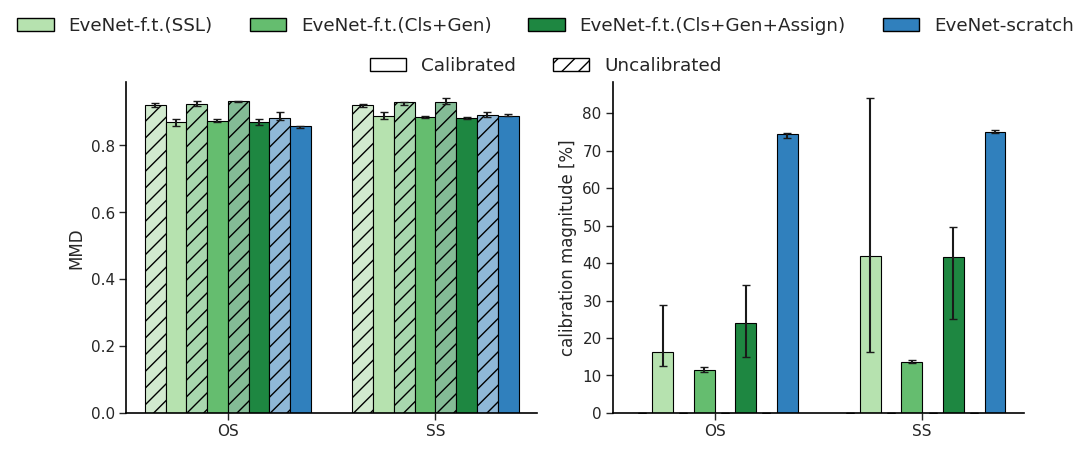

In [3]:
import json
with open("data/AD/boostrap_summary.json", "r") as f:
    boostrap_summary = json.load(f)
plot_aftercut_naturestyle(boostrap_summary, label_right="calibration magnitude [%]")

In [4]:
def compute_channel_significance(model_stats, cl=0.68):
    """
    Compute median and 68% CL per model per channel.
    Returns a DataFrame: model | channel | median | lower | upper
    """
    records = []
    for model, channels in model_stats.items():
        for channel, qvals in channels.items():
            q2 = qvals
            lower_p = (1 - cl)/2*100
            upper_p = (1 + cl)/2*100
            median = np.median(q2)
            lower = np.percentile(q2, lower_p)
            upper = np.percentile(q2, upper_p)
            records.append({
                "model": model,
                "channel": channel,
                "median": median,
                "lower": lower,
                "upper": upper,
                "number": len(qvals)
            })
    return pd.DataFrame(records)

In [5]:
with open("data/AD/significance_summary.json", "r") as f:
    significance_summary = json.load(f)
df_summary = compute_channel_significance(significance_summary)

In [6]:
df_summary

,model,channel,median,lower,upper,number
0,EveNet-f.t.(SSL),train-OS-test-OS,6.550111,6.221759,6.880985,1598
1,EveNet-f.t.(SSL),train-OS-test-SS,0.624803,0.000000,1.284387,1598
2,EveNet-f.t.(SSL),train-SS-test-OS,3.055280,1.358638,4.731585,1600
3,EveNet-f.t.(SSL),train-SS-test-SS,0.586913,0.202540,0.977685,1600
4,EveNet-f.t.(SSL)-calibrated,train-OS-test-OS,7.411852,6.955742,7.851985,1600
5,EveNet-f.t.(SSL)-calibrated,train-OS-test-SS,0.634436,0.000000,1.482444,1600
6,EveNet-f.t.(SSL)-calibrated,train-SS-test-OS,1.325930,0.074217,2.544419,1600
7,EveNet-f.t.(SSL)-calibrated,train-SS-test-SS,0.888612,0.423338,1.388237,1600
8,EveNet-f.t.(Cls+Gen),train-OS-test-OS,6.350548,6.028326,6.683591,1600
9,EveNet-f.t.(Cls+Gen),train-OS-test-SS,0.579893,0.000000,1.257762,1600


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import os

def plot_channel_bundled_bar_nature(
    model_stats,
    figsize=(10,5),
    show_error=True,
    var="median",               # "median" or "mean"
    output_dir="plots",
    label_ylabel=r"Median significance $\pm 68\%$ CL",
    y_min=None
):
    """
    Nature-style grouped bar plot:
    - per channel (x axis)
    - bars: models
    - solid = calibrated, hatched = uncalibrated
    - colors synchronized with your full project style
    """

    os.makedirs(output_dir, exist_ok=True)

    # -------------------------------------------------------
    # Prepare dataframe
    # -------------------------------------------------------
    records = []
    for model, channels in model_stats.items():
        calibrated = "-calibrated" in model
        base_model = model.replace("-calibrated", "")

        for channel, qvals in channels.items():
            arr = np.asarray(qvals)
            med = np.nanmedian(arr)
            lo  = np.nanpercentile(arr, 16)
            up  = np.nanpercentile(arr, 84)
            mean = np.nanmean(arr)

            records.append({
                "model": base_model,
                "calibrated": calibrated,
                "channel": channel,
                "median": med,
                "mean": mean,
                "lower": lo,
                "upper": up,
            })
            
    df = pd.DataFrame(records)

    # -------------------------------------------------------
    # Nature-style aesthetic
    # -------------------------------------------------------
    sns.set_theme(style="white", font_scale=1.2)
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "pdf.fonttype": 42,
    })

    # -------------------------------------------------------
    # Model color palette (SYNCED WITH YOUR NATURE STYLE)
    # -------------------------------------------------------
    greens = sns.color_palette("Greens", 12)
    blues  = sns.color_palette("Blues", 12)

    MODEL_COLORS = {
        "EveNet-f.t.(SSL)": greens[3],
        "EveNet-f.t.(Cls+Gen)": greens[6],
        "EveNet-f.t.(Cls+Gen+Assign)": greens[9],
        "EveNet-scratch": blues[8],
    }

    # Which models appear?
    detected = sorted(df["model"].unique())
    model_list = [m for m in MODEL_COLORS.keys() if m in detected]

    # fallback safety
    if len(model_list) == 0:
        palette = sns.color_palette("viridis", len(detected))
        MODEL_COLORS = {m: palette[i] for i,m in enumerate(detected)}
        model_list = detected

    n_models = len(model_list)

    channels = sorted(df["channel"].unique())
    n_channels = len(channels)

    total_bars_per_group = n_models * 2  # cal + uncal
    bar_width = 0.8 / total_bars_per_group
    # -------------------------------------------------------
    # Plotting
    # -------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    for i, model in enumerate(model_list):
        for j, calibrated in enumerate([False, True]):

            vals, lo_err, hi_err = [], [], []

            for ch in channels:
                row = df[
                    (df["model"] == model)
                    & (df["channel"] == ch)
                    & (df["calibrated"] == calibrated)
                ]

                if row.empty:
                    vals.append(np.nan)
                    lo_err.append(0)
                    hi_err.append(0)
                else:
                    center = row[var].values[0]
                    lower  = row["lower"].values[0]
                    upper  = row["upper"].values[0]
                    vals.append(center)
                    lo_err.append(center - lower)
                    hi_err.append(upper - center)

            xpos = (
                np.arange(n_channels)
                + (i * 2 + j - total_bars_per_group / 2 + 0.5) * bar_width
            )

            color = MODEL_COLORS[model]
            hatch = None if calibrated else "//"
            fill_color = color if calibrated else sns.light_palette(color, 3)[1]

            yerr = np.array([lo_err, hi_err])  # shape (2, N)


            ax.bar(
                xpos,
                vals,
                width=bar_width,
                yerr=yerr if show_error else None,
                color=fill_color,
                edgecolor="black",
                hatch=hatch,
                linewidth=0.8,
                error_kw=dict(
                    lw=1.0,
                    capsize=3,
                    capthick=1,
                    ecolor="black",
                ),
            )

    ax.set_xticks(np.arange(n_channels))
    ax.set_xticklabels(channels, rotation=25, ha="right")
    ax.set_ylabel(label_ylabel)
    apply_nature_axis_style(ax)
    if y_min is not None:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(bottom=y_min, top=max(y_max := ymax, y_min))

    sns.despine(ax=ax)

    # -------------------------------------------------------
    # Shared 2-row legend (Nature style)
    # -------------------------------------------------------
    model_handles = [
        Patch(facecolor=MODEL_COLORS[m], edgecolor="black", label=m)
        for m in model_list
    ]
    cal_handles = [
        Patch(facecolor="white", edgecolor="black", hatch="",   label="Calibrated"),
        Patch(facecolor="white", edgecolor="black", hatch="//", label="Uncalibrated"),
    ]

    fig.legend(
        handles=model_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(model_handles),
        frameon=False,
    )
    fig.legend(
        handles=cal_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=2,
        frameon=False,
    )

    plt.tight_layout()

    # Save
    out_pdf = os.path.join(output_dir, "summary_bundled_bar.pdf")
    out_png = os.path.join(output_dir, "summary_bundled_bar.png")
    fig.savefig(out_pdf, bbox_inches="tight", dpi=300)
    fig.savefig(out_png, bbox_inches="tight", dpi=300)

    plt.show()
    plt.close(fig)

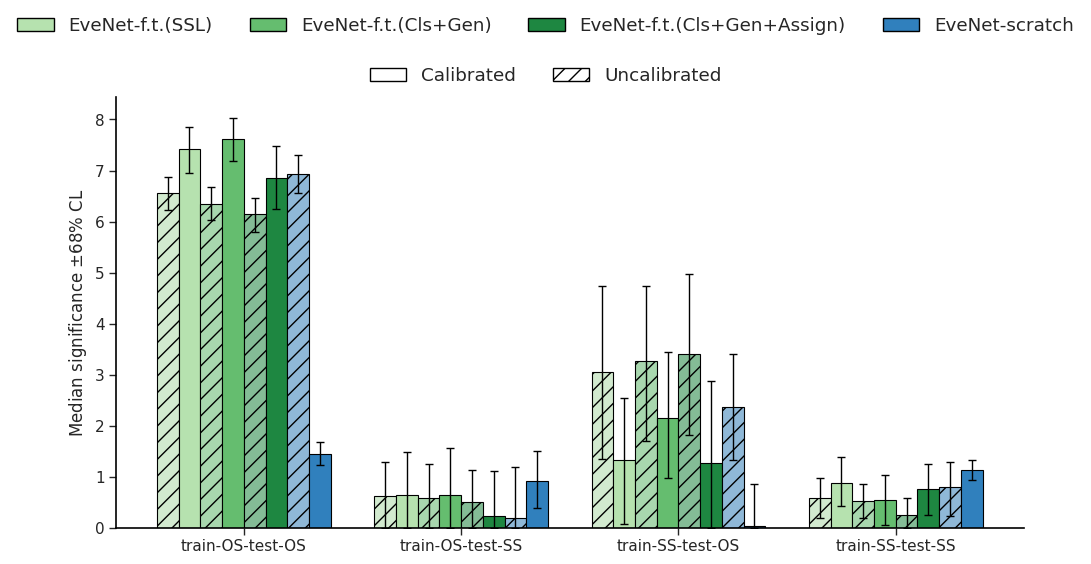

In [8]:
plot_channel_bundled_bar_nature(significance_summary, show_error = True, var = "median")
